# Trucks only problem #

Install necessary packages

In [24]:
from gurobipy import Model,GRB,LinExpr,quicksum
import numpy as np
from scipy.spatial import distance
import os
import socket
from load_dataset import Dataset

For Ugo's laptop

In [25]:

# Define the node name or another identifier of your laptop
my_laptop_node = 'Ugos-MacBook-Pro.local'

# Get the current system's node name using socket.gethostname()
current_node = socket.gethostname()

if current_node == my_laptop_node:
    # Set the environment variable for Gurobi license file
    os.environ["GRB_LICENSE_FILE"] = "/Users/ugomunzi/gurobi/licenses/gurobi.lic"
    print("Gurobi license path set for Ugo's MacBook Pro.")
else:
    print("Not Ugo's MacBook Pro, using default or no specific license settings.")


Gurobi license path set for Ugo's MacBook Pro.


Define model parametres

In [26]:
## MODEL PARAMETERS ##
W_T = 1500 #empty weight truck [kg]
Q_T = 1000 #load capacity of trucks [kg]
#W_D = 25 #empty weight drone [kg]
#Q_D = 5 #load capacity of drones [kg]
C_T = 25 #travel cost of trucks per unit distance [monetary unit/km]
#C_D = 1 #travel cost of drones per unit distance [monetary unit/km]
C_B = 500 #basis cost of using a truck equipped with a drone [monetary unit]
#E = 0.5 #maximum endurance of empty drones [hours]
S_T = 60 #average travel speed of the trucks [km/h]
#S_D = 65 #average travel speed of the drones [km/h]

Define Big M constant

In [27]:
M = 1e9 #big M constant for big M method(1e9 is largest order of magnitude before numerical issues arise in Gurobi)

Load Dataset using load_dataset.py

In [28]:
## LOAD DATASET ##
current_dir = os.getcwd()
# Select which data folder to use
data_subfolder = '0.3'
data_subfoldercopy = '0.3_copy'
data_num_nodes = '40'
data_area = '40'

data_file_name = f'{data_num_nodes}_{data_area}_{data_subfoldercopy}'
dataset_path = f'dataset/{data_subfolder}/{data_file_name}.txt'
output_solution_file_path = os.path.join(current_dir, data_file_name + '_solution.sol')#used to save solution file
output_model_file_path = os.path.join(current_dir, data_file_name + '_model.lp')#used to save model file
dataset = Dataset(dataset_path)



Pre-processing

In [29]:
## FUNCTIONS ##
def get_manhattan_distance(data):
    """
    Returns a dictionary with manhattan distances between all nodes in dataset
    """
    distance_dict = {}
    for node1 in data.keys():
        for node2 in data.keys():
            distance_dict[node1, node2] = distance.cityblock([data[node1]['X'], data[node1]['Y']], [data[node2]['X'], data[node2]['Y']])
    return distance_dict

def get_time_dict(data, S_T, distance_dict):
    """
    Returns a dictionary with travel times between all nodes in dataset
    """
    time_dict = {}
    for node1 in data.keys():
        for node2 in data.keys():
            time_dict[node1, node2] = distance_dict[node1, node2] / S_T
    return time_dict

def check_in_x_var(i, j):
    """Check if the route from node i to node j is valid instead of having to pass bunch of conditions in each constraint.
    Conditions:
        1- cant travel between same node (i != j)
        2- cant leave return depot D1 (i != 'D1')
        3- cant arrive at start depot D0 (j != 'D0')
        4- cant travel from D0 to D1 (not (i == 'D0' and j == 'D1'))
            note that constraints 2 & 3 already ensure you cant travel from D1 to D0
    """
    if i != j and i != 'D1' and j != 'D0' and not (i == 'D0' and j == 'D1'):
        return True
    return False

def get_cost_obj(C_T, truck_distance_dict, active_routes_truck, cost_weight=1):
    """
    Returns the cost objective value for the model after it has optimised
    """
    cost_obj = 0
    for truck in active_routes_truck.keys():
        for route in active_routes_truck[truck]:
            i, j, _, _ = route
            cost_obj += cost_weight * C_T * truck_distance_dict[i, j]
    return cost_obj

def get_environmental_obj(W_T, truck_distance_dict, active_routes_truck, environmental_weight=1):
    """
    Returns the environmental objective value for the model after it has optimised
    """
    environmental_obj = 0
    for truck in active_routes_truck.keys():
        for route in active_routes_truck[truck]:
            i, j, _, _ = route
            environmental_obj += environmental_weight * W_T * truck_distance_dict[i, j]
    return environmental_obj

def get_time_obj(active_routes_truck, time_weight=1):
    """
    Returns the time objective value for the model after it has optimised
    """
    time_obj = 0
    for truck in active_routes_truck.keys():
        for route in active_routes_truck[truck]:
            _, _, timestamp, _ = route
            time_obj = max(time_obj, timestamp)
    return time_weight * time_obj


num_trucks = 5 # reduce from 10 to five to speed up optimisisation (basically half the number of variables)
truck_distance_dict = get_manhattan_distance(dataset.data)
truck_time_dict = get_time_dict(dataset.data, S_T, truck_distance_dict)

#definitions of N_0, N and N_plus follow from paper
N = list(dataset.data.keys()) #set of nodes with depot at start (D0) and at end (D1)
N_customers = N.copy()
N_customers.remove('D0')
N_customers.remove('D1')
Tr = [f'Tr{i}' for i in range(1, num_trucks+1)] #set of trucks

Define the model

In [30]:
# Create a new model
model = Model("Truck_Routing")

# Define decision variables
x = model.addVars(Tr, [(i, j) for i in N for j in N if check_in_x_var(i, j)], lb=0, ub=1, vtype=GRB.BINARY, name='x')
y = model.addVars(Tr, lb=0, ub=1, vtype=GRB.BINARY, name='y')
t = model.addVars(Tr, N, lb=0, vtype=GRB.CONTINUOUS, name='t')
t_max = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name='t_max') #used for the minimising the max delivery time (find max time of all trucks, not each individual truck)
# Define payload variables for each truck and node (used for calculating weight of truck when travelling between nodes)
payload = model.addVars(Tr, [(i, j) for i in N for j in N if check_in_x_var(i, j)], lb=0, ub=Q_T, vtype=GRB.CONTINUOUS, name='payload')#payload present on truck when travelling between i to j, gets updated after each delivery to a customer
# Define dynamic weight variables
W_dynamic = model.addVars(Tr, [(i, j) for i in N for j in N if check_in_x_var(i, j)], lb=0, vtype=GRB.CONTINUOUS, name='W_dynamic')#similar to payload but includes the empty weight of truck aswell

# Objective 1: Cost both due to transportation and base cost of using truck if active)
cost_obj = quicksum(C_T * truck_distance_dict[i,j] * x[truck,i,j] for i in N for j in N if check_in_x_var(i, j) for truck in Tr) + \
           quicksum(C_B * y[truck] for truck in Tr)
# Objective 2: environmental_obj is distance[i,j] * Weight* x[v,i,j] for all v,i,j (i.e. energy consumption)
environmental_obj = quicksum(truck_distance_dict[i,j] * W_dynamic[truck, i, j] * x[truck,i,j] for i in N for j in N if check_in_x_var(i, j) for truck in Tr)
# Objective 3: minimise max delivery time for each truck
time_obj = t_max

#set weights such that all cost objectives are in same order of magnitude (approx 10^3, time is larger to enforce optimiser to use multiple trucks to reduce max delivery time)
#below weights enforce the optimiser to use multiple trucks to reduce max delivery time
cost_weight = 1
environmental_weight = 0.01
time_weight = 10000

"""
cost_weight = 1
environmental_weight = 1 
time_weight = 1
"""
obj = cost_weight * cost_obj + environmental_weight * environmental_obj + time_weight * time_obj
model.setObjective(obj, GRB.MINIMIZE)

model.update()

Constraint 1: Each customer is visited by exactly one truck

In [31]:
# Constraint 1: Each customer is visited by exactly one truck

for customer in N_customers:
    # Initialize the sum for the current customer
    sum_for_current_customer = 0

    # Loop over each truck
    for truck in Tr:
        # Loop over each node
        for node in N:
            # Skip if customer is equal to node
            if check_in_x_var(node, customer):
                # Add the variable to the sum
                sum_for_current_customer += x[truck, node, customer]

    # The sum for the current customer must be equal to 1
    model.addConstr(sum_for_current_customer == 1, name=f'Customer_{customer}_visited_once')

Constraint 2: Each truck must leave the depot if active

In [32]:
# Constraint 2: Each truck must leave the depot if active

for truck in Tr:
    sum_for_current_vehicle = quicksum(x[truck, 'D0', customer] for customer in N_customers)
    model.addConstr(sum_for_current_vehicle == y[truck], name=f'Truck_leaves_depot_{truck}')

Constraint 3: Each vehicle arrives at depot if active

In [33]:

# Constraint 3: Each truck must return to the depot if active

for truck in Tr:
    sum_for_current_vehicle = quicksum(x[truck, customer, 'D1'] for customer in N_customers)
    model.addConstr(sum_for_current_vehicle == y[truck], name=f'Truck_returns_to_depot_{truck}')

Constraint 4: If a vehicle arrives at a customer node it must also leave

In [34]:
# Constraint 4: If a truck arrives at a customer node it must also leave (flow balance)

for truck in Tr:
    for node in N_customers:
        model.addConstr(
            quicksum(x[truck, node, j] for j in N if check_in_x_var(node, j)) == 
            quicksum(x[truck, j, node] for j in N if check_in_x_var(j, node)),
            name=f'Flow_balance_{truck}_{node}'
        )

Constraint 5: Time at a node is equal or larger than time at previous nodes plus travel time (or irrelevant). Eliminates need for subtour constraints.

In [35]:
#Constraint 5: Time at a node is equal or larger than time at previous nodes plus travel time (or irrelevant). Eliminates need for subtour constraints.

# Add time constraints for all vehicles, nodes, and customers
for truck in Tr:
    for node in N:
        for customer in N:
            if check_in_x_var(node, customer):
                model.addConstr(
                    t[truck, customer] >= t[truck, node] + truck_time_dict[(node, customer)] - M * (1 - x[truck, node, customer]),
                    name=f'Time_{truck}_{node}_{customer}'
                )

Constraint 6: Payloads

In [36]:
# Constraint 6: The total payload delivered to the customer must be less or equal to the truck load capacity Q_T

for truck in Tr:
    model.addConstr(quicksum(dataset.data[i]['Demand'] * x[truck, i, j] for i in N for j in N if check_in_x_var(i, j)) <= Q_T, 
                    name=f'Payload_{truck}')

Constraint 7 : link y variable to x variable.

In [37]:
# Constraint 7: Link y variable to x variable : TRUCKS
#if any link in x (for each truck) is active -> y = 1
# can do this by checking if each truck leaves the depot (all trucks must leave depot if active)

for truck in Tr:
    model.addConstr(y[truck] == quicksum(x[truck, 'D0', i] for i in N_customers), name=f'Link_y{truck}_to_x_{truck}')

Constraint 8: Set departure time from depot D0 for each truck = 0

In [38]:
# Constraint 8: set departure time from depot D0 for each truck = 0

for truck in Tr:
    model.addConstr(t[truck, 'D0'] == 0, name=f'Departure_time_{truck}_D0')

Constraint 9: update time variables.

In [39]:
# Constraint 9: Update time variable for trucks
# Loop over each truck
for truck in Tr:
    # Loop over each node (destination)
    for j in N:
        if j != 'D0':  # Ensuring no calculation is made for the time to 'D0' as it's the starting point only
            # Initialize the sum for arriving at node j from any node i
            sum_for_arrival_to_j = quicksum((t[truck, i] + truck_time_dict[i, j]) * x[truck, i, j]
                                            for i in N if check_in_x_var(i, j))
            
            # Add the constraint that sets the arrival time at j based on departure times from all nodes i
            model.addConstr(t[truck, j] == sum_for_arrival_to_j, name=f'Update_time_{truck}_{j}')




Constraint 10: update max delivery time variable.

In [40]:
# Constraint 10: Update max delivery time variable
for truck in Tr:
    for node in N:
        # Add a constraint to the model that the maximum delivery time is greater than or equal to the delivery time to the customer for each vehicle
        model.addConstr(t_max >= t[truck, node], name=f'Update_max_delivery_time_{truck}_{node}')

CONSTRAINTS FOR DYNAMIC WEIGHTS AND PAYLOAD

Constraint 11: set payload for each truck at depot = sum of demand of all customers visited by truck

In [41]:
# Constraint 11: set payload for each truck at depot = sum of demand of all customers visited by truck
#note: this works, checked manually
for truck in Tr:
    sum_for_current_truck = 0
    for i in N:
        for j in N:
            if check_in_x_var(i, j):
                sum_for_current_truck += dataset.data[j]['Demand'] * x[truck, i, j]
        if check_in_x_var('D0', i):
            model.addConstr(payload[truck, 'D0', i] == sum_for_current_truck * x[truck, 'D0', i], name=f'Payload_{truck}_D0_{i}')

Constraint 12: each time truck delivers to a customer, the payload is updated

In [42]:
#Constraint 12: each time truck delivers to a customer, the payload is updated
for truck in Tr:
    for i in N:
        for j in N_customers:
            for k in N:
                """
                i is node which was previously visited by truck
                j is customer node where truck is delivering
                k is node where truck is going next
                """
                if check_in_x_var(i, j) and check_in_x_var(j, k):
                    model.addConstr(payload[truck, j, k] <= payload[truck, i, j] - dataset.data[j]['Demand'] * x[truck, i, j] + M * (1 - x[truck, i, j]), name=f'Payload_update_{truck}_{truck}_{i}_{j}_{k}')

Constraint 13: Explicitly set payload to zero for inactive routes (for some reason without this some inactive trucks have payload = 1000)

In [43]:
# Constraint 13: Explicitly set payload to zero for inactive routes (for some reason without this some inactive trucks have payload = 1000)
for truck in Tr:
    for i in N:
        for j in N:
            if check_in_x_var(i, j):
                model.addConstr(payload[truck, i, j] <= M * x[truck, i, j], name=f'Zero_inactive_payload_{truck}_{i}_{j}')

Constraint 14: update dynamic weight for each truck at each node (W_dynamic[truck, i, j] = W_T + payload[truck, i, j]) only when link (thus truck) is active

In [44]:
# Constraint 14: update dynamic weight for each truck at each node (W_dynamic[truck, i, j] = W_T + payload[truck, i, j]) only when link (thus truck) is active
for truck in Tr:
    for i in N:
        for j in N:
            if check_in_x_var(i, j):
                model.addConstr(W_dynamic[truck, i, j] == (W_T + payload[truck, i, j]) * x[truck, i, j], name=f'Update_dynamic_weight_{truck}_{i}_{j}')

Update, tune and run the model

In [45]:
# Update the model to integrate new variables
model.update()

# Write model to a file
model.write('TruckonlySimple.lp')

# Tune solver parameters
#model.tune()

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.OPTIMAL:
    print('Optimal objective: %g' % model.objVal)
    for v in model.getVars():
        if v.x > 0:
            print('%s: %g' % (v.varName, v.x))
else:
    print('Optimization was stopped with status %d' % model.status)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2514144 - for non-commercial use only - registered to u.___@student.tudelft.nl
Optimize a model with 10367 rows, 2416 columns and 33040 nonzeros
Model fingerprint: 0x68f0776b
Model has 780 quadratic objective terms
Model has 905 quadratic constraints
Variable types: 1631 continuous, 785 integer (785 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  QMatrix range    [1e+00, 5e+00]
  QLMatrix range   [1e-01, 2e+03]
  Objective range  [2e+02, 1e+04]
  QObjective range [1e-01, 2e+00]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve added 110 rows and 5 columns
Presolve time: 0.15s
Presolved: 16662 rows, 7701 columns, 78392 nonzeros
Pres

Post-processing

Active trucks: ['Tr1', 'Tr2', 'Tr3', 'Tr4']
Active routes for trucks: {'Tr1': [('D0', 'C11', 1.1233333349227905, 1509.4), ('C11', 'C5', 1.3016666682561238, 1508.1), ('C5', 'C3', 1.4950000015894447, 1506.3), ('C3', 'C9', 2.5733333349227783, 1504.8), ('C9', 'D1', 2.9833333333333334, 1500.0)], 'Tr2': [('D0', 'C12', 1.5433333333333321, 1509.0), ('C12', 'C4', 1.8383333333333134, 1506.0), ('C4', 'C8', 2.3366666666666465, 1501.2), ('C8', 'D1', 3.0866666666666362, 1500.0)], 'Tr3': [('D0', 'C10', 0.3133333921432504, 1512.2), ('C10', 'C6', 0.5283333921432531, 1509.1), ('C6', 'C2', 1.8033333921432535, 1504.6), ('C2', 'C1', 2.5816667254765866, 1501.7), ('C1', 'D1', 2.946666725476587, 1500.0)], 'Tr4': [('D0', 'C7', 0.63, 1501.9), ('C7', 'D1', 1.2600000000000002, 1500.0)]}
Cost objective/Total delivery cost [$]: 15415.0
Environmental objective [kg * km]: 9249.0
Time objective: 30866.666666666362
Max delivery time: 3 hours, 5 minutes, 11 seconds


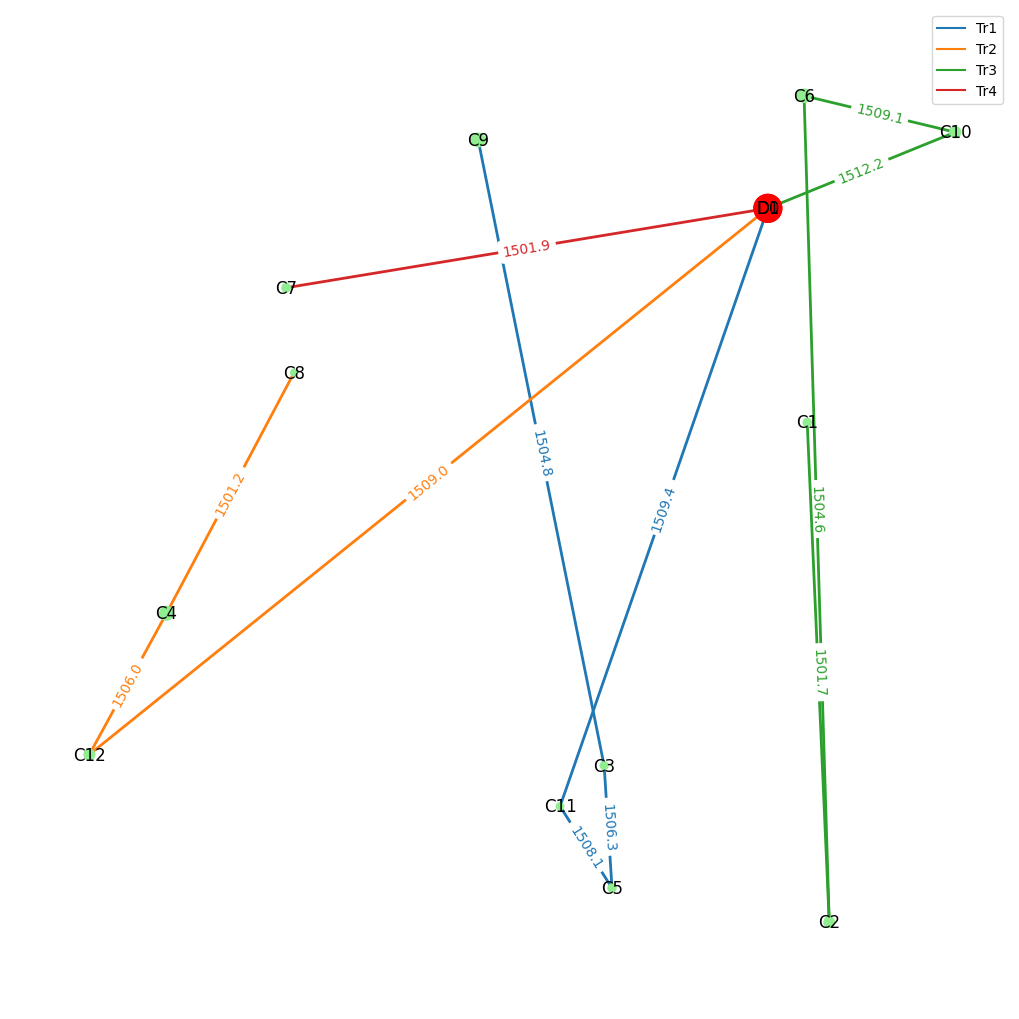

In [46]:
# Extract and store the solution
solution = {var.varName: var.x for var in model.getVars()}

# Extract active trucks
active_trucks = [v for v in Tr if 'T' in v and solution[f'y[{v}]'] >= 0.99]

# Extract routes for active trucks
active_routes_truck = {} #for each truck and pair of nodes (i, j) store (node from, node to, timestamp, weight) of truck when travelling between i and j (ordered by increasing time)
for truck in active_trucks:
    active_routes_truck[truck] = []
    for node_from in N:
        for node_to in N:
            if node_from != node_to and solution.get(f'x[{truck},{node_from},{node_to}]', 0) >= 0.99:
                timestamp = solution.get(f't[{truck},{node_to}]', 0)
                weight = solution.get(f'W_dynamic[{truck},{node_from},{node_to}]', 0)
                active_routes_truck[truck].append((node_from, node_to, timestamp, np.round(weight, 1)))

# Sort the routes for each truck according to the timestamps
for truck in active_trucks:
    active_routes_truck[truck].sort(key=lambda x: x[2])

print('Active trucks:', active_trucks)
print('Active routes for trucks:', active_routes_truck)

# Print each seperate objective value after optimisation
print('Cost objective/Total delivery cost [$]:', get_cost_obj(C_T, truck_distance_dict, active_routes_truck, cost_weight=cost_weight))
print('Environmental objective [kg * km]:', get_environmental_obj(W_T, truck_distance_dict, active_routes_truck, environmental_weight=environmental_weight))
print('Time objective:', get_time_obj(active_routes_truck, time_weight=time_weight))

#convert t_max to hours, minutes, seconds
t_max_hours = model.getVarByName('t_max').x
t_max_minutes, t_max_seconds = divmod(t_max_hours * 3600, 60)
t_max_hours, t_max_minutes = divmod(t_max_minutes, 60)
print('Max delivery time: {} hours, {} minutes, {} seconds'.format(int(t_max_hours), int(t_max_minutes), int(t_max_seconds)))

#use plotting method in dataset class to visualise
dataset.plot_data(show_demand=False, scale_nodes=True, show_labels=True, active_routes=active_routes_truck, show_weights=True)
#save solution to .sol file
model.write(output_solution_file_path)
#save model to .lp file
model.write(output_model_file_path)